In [2]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-Python/
# http://www.cnblogs.com/haobang008/p/5909207.html
# xgboost 参数调优指南

import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams



/home/zhangguoqiang/genv/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/zhangguoqiang/genv/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [5]:
# train model
rcParams['figure.figsize'] = 12, 4
home_dir = os.getcwd()
file_name = os.path.join(home_dir, 'data/train_modified.csv')
print "file_name:", file_name

train_data = pd.read_csv(file_name)
target = "Disbursed"
idCol = "ID"
train_data.first

file_name: /home/zhangguoqiang/code/shell/deeplearning/alg/xgbdt/data/train_modified.csv


<bound method DataFrame.first of        Disbursed  Existing_EMI           ID  Loan_Amount_Applied  \
0            0.0           0.0  ID000002C20             300000.0   
1            0.0           0.0  ID000004E40             200000.0   
2            0.0           0.0  ID000007H20             600000.0   
3            0.0           0.0  ID000008I30            1000000.0   
4            0.0       25000.0  ID000009J40             500000.0   
5            0.0       15000.0  ID000010K00             300000.0   
6            0.0           0.0  ID000011L10                  6.0   
7            0.0        2597.0  ID000012M20             200000.0   
8            0.0           0.0  ID000013N30                  0.0   
9            0.0           0.0  ID000014O40             300000.0   
10           0.0           0.0  ID000016Q10            1000000.0   
11           0.0           0.0  ID000018S30             140000.0   
12           0.0           0.0  ID000019T40             500000.0   
13           0.

### Step 1: fix learning rate and number of estimators for tuning tree-based paramters

In [6]:
train_data.dtypes

Disbursed                        float64
Existing_EMI                     float64
ID                                object
Loan_Amount_Applied              float64
Loan_Tenure_Applied              float64
Monthly_Income                     int64
Var4                               int64
Var5                               int64
Age                                int64
EMI_Loan_Submitted_Missing         int64
Interest_Rate_Missing              int64
Loan_Amount_Submitted_Missing      int64
Loan_Tenure_Submitted_Missing      int64
Processing_Fee_Missing             int64
Device_Type_0                    float64
Device_Type_1                    float64
Filled_Form_0                    float64
Filled_Form_1                    float64
Gender_0                         float64
Gender_1                         float64
Var1_0                           float64
Var1_1                           float64
Var1_2                           float64
Var1_3                           float64
Var1_4          

In [7]:
predictors = [x for x in train_data.columns if x not in [target, idCol]]
len(predictors)

49


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.891681
XGBClassifier modelfit end cost time:  22.308113


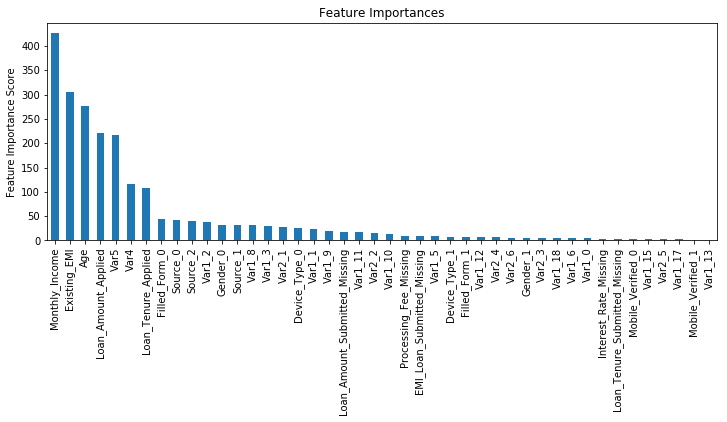

In [ ]:
# Choose all predictors except target & IDcols
start_time = datetime.now()
predictors = [x for x in train_data.columns if x not in [target, idCol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_data, predictors)

print "XGBClassifier modelfit end cost time: ", (datetime.now()-start_time).total_seconds()

### step 2: Tune max_depth and min_child_weight

> max_depth 和min_child_weight 对模型输出会产生比较大影响

In [9]:
# 此部分使用高负荷的网格搜索

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

start_time = datetime.now()
# XGBClassifier 学习率和step 1 一样，estimators调整为140
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=140,
                                                max_depth=5,
                                                 min_child_weight=1,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=7,
                                                scale_pos_weight=1,
                                                seed=27), 
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs=7,
                        iid=False,
                        cv=5)
print "gsearch end_time1: ", (datetime.now() - start_time).total_seconds()



gsearch end_time1:  0.000351


In [ ]:
gsearch1.fit(train_data[predictors],train_data[target])
print "gsearch end_time2: ", (datetime.now() - start_time).total_seconds()
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:

param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=140,
                                                max_depth=5,
                                                min_child_weight=2,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=8,
                                                scale_pos_weight=1,
                                                seed=27), 
                        param_grid = param_test2,
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False,
                        cv=5)
gsearch2.fit(train_data[predictors],train_data[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                 n_estimators=140,
                                                 max_depth=4,
                                                 min_child_weight=2,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 colsample_bytree=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4, 
                                                 scale_pos_weight=1,
                                                 seed=27), 
                         param_grid = param_test2b,
                         scoring='roc_auc',
                         n_jobs=4,
                         iid=False,
                         cv=5)
gsearch2b.fit(train_data[predictors],train_data[target])

modelfit(gsearch3.best_estimator_, train_data, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_


### step3 : Tune gamma

In [ ]:
# 从结果看， gamma初始值为0是最合适的

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140,
                                                  max_depth=4,
                                                  min_child_weight=6,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=7,
                                                  scale_pos_weight=1,seed=27), 
                        param_grid = param_test3,
                        scoring='roc_auc',
                        n_jobs=7,
                        iid=False,
                        cv=5)
gsearch3.fit(train_data[predictors],train_data[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

# step 4: tune subsample and colsample_bytee

> subsample 和GBM中的参数一样，用于控制每棵树的随机采样的比例

> colsample_bybtree 和GBM中的max_features中的参数一样，用于控制每棵树，随机采样的列数的占比(每一列是一个特征)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=177,
                                                  max_depth=4,
                                                  min_child_weight=6,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=7,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=7,
                        iid=False,
                        cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# 步长设置为0.05
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=177,
                                                  max_depth=4,
                                                  min_child_weight=6,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test5,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

# step 5: tuning regularization parameters

> 由于xgboost提供了gamma参数用于空值过拟合，因此，正则化参数很少用到

> 调整参数，先是在一个大的范围内调整，然后在某个值小范围调整

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)


# step 6: reducing learning rate

> 最后一步，降低学习率，可以使用XGBoost中的cv函数来实现


In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

### 分享两个重要的思想

> 1. 仅仅靠参数调整和模型的小幅优化，想让模型性能有质的提升是不可能的

> 2. 想让模型有质的飞跃需要其它手段，例如feature engineering(特征工程), ensemble of models(组合模型), stacking(堆叠等)